In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer, path):
        assert mode in ['train', 'val']
        self.mode = mode
        self.df = pd.read_csv(path + mode + '.tsv', sep='\t').fillna('')
        self.len = len(self.df)
        self.tokenizer = tokenizer # BERT tokenizer
        
    def __getitem__(self, idx):
        statement, label = self.df.iloc[idx, :].values
        label_tensor = torch.tensor(label)
            
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
            
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
            
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
            
        return (tokens_tensor, segments_tensor, label_tensor)
        
    def __len__(self):
        return self.len

In [3]:
# reforming the dataset to fit the model

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
        
    # zero padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0,1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 16

In [4]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output
from transformers import BertTokenizer

MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_LABELS)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
trainset = FakeNewsDataset('train', tokenizer=tokenizer, path='./')
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

In [6]:
# fine-tuning of BERT

from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)
model.to(device)

model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0
    
    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors,
                      token_type_ids=segments_tensors,
                      attention_mask=masks_tensors,
                      labels=labels)
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        
        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
        
        train_loss += loss.item()
        
        loop.set_description(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
        loop.set_postfix(acc=train_acc, loss=train_loss/(batch_idx+1))

device: cuda:0


  0%|          | 0/1160 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
torch.save(model, 'BERT/best_model.pth')

In [7]:
valset_fnn = FakeNewsDataset('val', tokenizer=tokenizer, path='./')
print('fnn valset size:', valset_fnn.__len__())

fnn valset size: 4639


In [8]:
valloader_fnn = DataLoader(valset_fnn, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

def evaluate(valloader):
    true = []
    predictions = []
    with torch.no_grad():
        model.eval()
        for data in valloader:
            if next(model.parameters()).is_cuda:
                data = [t.to(device) for t in data if t is not None]

            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            val_outputs = model(input_ids=tokens_tensors,
                               token_type_ids=segments_tensors,
                               attention_mask=masks_tensors)

            logits = val_outputs[0]
            _, pred = torch.max(logits.data, 1)

            labels = data[3]
            true.extend(labels.cpu().tolist())
            predictions.extend(pred.cpu().tolist())

    cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot()

    accuracy = accuracy_score(true, predictions)
    precision = precision_score(true, predictions)
    recall = recall_score(true, predictions)
    f1 = f1_score(true, predictions)
    
    print('\nAccuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)


Fake News Net:
Confusion Matrix:
[[0.86116224 0.1937799 ]
 [0.13883776 0.8062201 ]]

Accuracy: 0.8512610476395776
Precision: 0.8611622403365764
Recall: 0.9528658713994763
F1 Score: 0.904696132596685


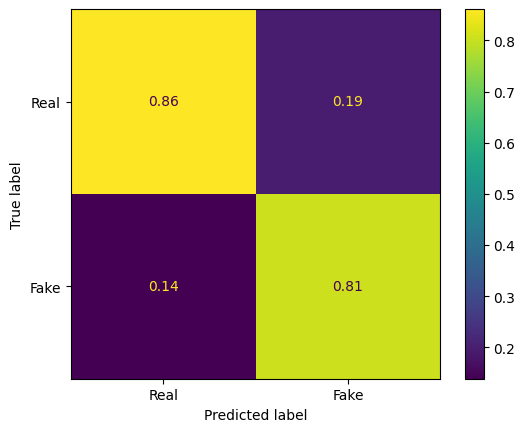

In [12]:
print('Fake News Net:')
print('Confusion Matrix:')
evaluate(valloader_fnn)